In [32]:
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

In [42]:
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

IMG_X, IMG_Y = 300, 400
# length and width of blocks (fixed for now)
block_l, block_w = 25, 25
num_images = 50

# img_list = []
true_coords = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
for i in range(num_images):
    orient = 0 # degrees
    img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

    # block_l and _w offset so blocks don't run off edge of image
    rand_x = int(np.random.rand() * (IMG_X-block_l))
    rand_y = int(np.random.rand() * (IMG_Y-block_w))

    true_coords.append(np.array((rand_x, rand_y)))

    rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                    rand_y))
    idraw = ImageDraw.Draw(img)
    idraw.polygon(rect_vertices, fill='white')

    # use a truetype font
    #font = ImageFont.truetype("DejavuSans.ttf", 15)
    #font = ImageFont.truetype("Arial.ttf",14)
    #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')


    img.save('./data/rect'+str(i)+'.png')


    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

In [43]:
# Hyper parameters
num_epochs = 35 
num_classes = 2
batch_size = 10
learning_rate = 0.001

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=true_coords)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

const = 16*97*72


class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(const, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.view(-1, 3, 400, 300)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if (i_batch+1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))

Training model now...
Epoch [1/35], Step [1/5], Loss: 31865.7852
Epoch [1/35], Step [2/5], Loss: 24503.2715
Epoch [1/35], Step [3/5], Loss: 23115.9160
Epoch [1/35], Step [4/5], Loss: 26240.4609
Epoch [1/35], Step [5/5], Loss: 29449.6465
Epoch [2/35], Step [1/5], Loss: 8246.0332
Epoch [2/35], Step [2/5], Loss: 13452.0244
Epoch [2/35], Step [3/5], Loss: 4255.1592
Epoch [2/35], Step [4/5], Loss: 7020.5352
Epoch [2/35], Step [5/5], Loss: 14358.9551
Epoch [3/35], Step [1/5], Loss: 4867.4443
Epoch [3/35], Step [2/5], Loss: 3885.5684
Epoch [3/35], Step [3/5], Loss: 1988.8433
Epoch [3/35], Step [4/5], Loss: 6469.7471
Epoch [3/35], Step [5/5], Loss: 5224.8535
Epoch [4/35], Step [1/5], Loss: 5343.7568
Epoch [4/35], Step [2/5], Loss: 5311.8833
Epoch [4/35], Step [3/5], Loss: 5229.7847
Epoch [4/35], Step [4/5], Loss: 4639.0986
Epoch [4/35], Step [5/5], Loss: 5386.0947
Epoch [5/35], Step [1/5], Loss: 2045.7527
Epoch [5/35], Step [2/5], Loss: 1245.0614
Epoch [5/35], Step [3/5], Loss: 3539.7554
Epoch

In [45]:
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

10
truth tensor([250., 262.])
net output tensor([250.6488, 261.7675], grad_fn=<SelectBackward>)
torch.Size([3, 400, 300])
net output: 


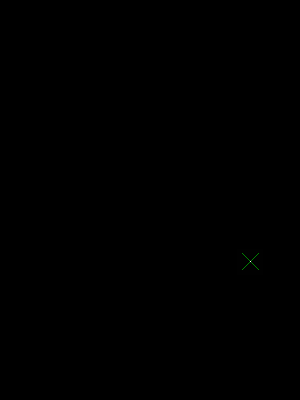

truth label: 


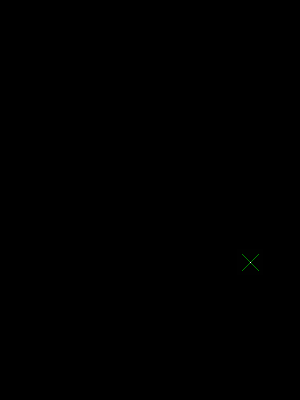

In [51]:
import torchvision 
import matplotlib.pyplot as plt
import copy
from IPython.display import display # to display images
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))
    
    #imgA = torchvision.transforms.ToPILImage()(images[0])
    #draw = ImageDraw.Draw(imgA)
    #a,b = tuple(outputs[0])
    #draw.point(tuple(outputs[0]), fill='white')
    #imgA.show()

    # _, predicted = torch.max(outputs, 1)

    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
 
n =5 
outputs = model(images)
print(len(labels))
print('truth', labels[n])
print('net output', outputs[n])

images_copy = copy.deepcopy(images)
print(images_copy[n].size())
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])
#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

[250 262]
tensor([[250.6488, 261.7675]], grad_fn=<ThAddmmBackward>)


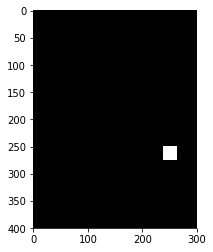

In [65]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 2

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
output = model(image_tensor)

print(true_coords[n])
print(output)
plt.imshow(image)


torch.Size([10, 3, 400, 300])
tensor(255.) tensor(0.) torch.Size([3, 806, 2418])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


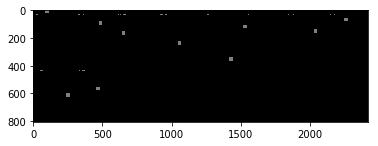

In [39]:
#img = Image.new('RGB', (300,400), 'gray')
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize
a = a.numpy()
ran = a.max() - a.min()
a = (a/ran) - 0.5
plt.imshow(np.transpose(a, (1,2,0)))